# Building a convnet for ✊✋✌
This presents how to build a convnet from scratch to classify images of rock-paper-scissors.  It is meant as a teaching activity to demonstrate the following concepts in practice:
- how images are represented and handled in software
- how to prepare a machine learning dataset
- how a full machine learning pipeline looks
- data preprocessing
- data augmentation and its importance in a 
- overfitting, underfitting

We use the high-level deep learning library Keras, but the concepts are general and we don't put much focus on the specifics of the code.

## Step 0: defining the problem
What problem do we want to solve, exactly?  We want to build a piece of software that, given an image as input that represents an hand making one of the three ✊✋✌ gestures, produces as output a classification of the image in one of the three classes.

In the following, we will adopt this convention
- class 0 is ✊ rock
- class 1 is ✋ paper
- class 2 is ✌ scissors

## Step 1: building a dataset
We are starting from scratch, so we need to shoot our own dataset; the best option is that multiple students/groups shoot plenty of images in parallel and then the data is somehow collected.  Whatever the process, in the end we want to have all pics in three different directories, one per class.  Format can be either jpg or png, and landscape/portrait, aspect ratio and resolution don't matter and can be mixed.

With some attention to logistics, this can be done in about 10-30 minutes.

Guidelines for shooting images. 
- We don't need high resolution: use the lowest resolution/quality allowed by the phone (this reduces the size of the dataset and speeds up data transfer).
- The hand must be more or less in the center of the image; it should not fill the whole image, but it should not be too small either.  ![caption](figures/guidelines.jpg)
- we want the dataset to represent as much variability as possible: if we want the classifier to work for all hand orientations, try to have examples for all of them; if we want to handle many different lightling conditions, try to have some pictures for different lightings;
- avoid poses that are ambiguous, unless you want to make your job harder: e.g., don't include in the dataset images of paper or scissors taken from the side;
- avoid having two images in the dataset that are almost the same: change the camera and hand pose at least a little bit; this is important because in the following code we randomly split training and testing data.

Remember that we need the images for each class to be in its own directory. To make this simpler, it helps to shoot first all images of rock, then all images of paper, then all images of scissors, and finally sort the images by time in the file manager and group them accordingly.

Place all images in three directories named `c0/`, `c1/`, and `c2/`.  Make sure that each directory only contains image files.

## Step 2: read in images and have a look at them
Let's first import what we need

In [1]:
%matplotlib nbagg

import matplotlib.pyplot as plt
import pathlib
import skimage
import skimage.transform
import skimage.viewer
import pandas as pd
import numpy as np
import time
import keras.utils.np_utils

dnames = ["D{}".format(i) for i in range(1,6)]+["testing"]
ddirs=[pathlib.Path(".")/"datasets"/"final split"/dn for dn in dnames] # directories of the dataset

cdirs={}
for ddir in ddirs:
    cdirs.update({ddir/"c0":0,
                  ddir/"c1":1,
                  ddir/"c2":2})
names = ["rock", "paper", "scissors"]
for d in cdirs.keys():
    assert(d.exists())

Using TensorFlow backend.


Let's try to read the first image from the first directory, and visualize it.  Note that the tool allows you to zoom in order to see the individual pixels.

In [ ]:
im = skimage.io.imread(list(list(cdirs.keys())[0].glob("*"))[0])
viewer=skimage.viewer.ImageViewer(im)
viewer.show()
# Note: you have to close the window to continue

We now read in all images, cut the central square (with an edge as long as the shorter dimension), and resize it to 500x500 pixels.  Whatever the initial size and orientation of the images, we will end up with a bunch of 500x500 RGB squares in float32.  These should be small enough that unless the dataset is huge, all should fit in memory.  We make a pandas dataframe with the data, with two columns: "image" (the image) and "label".

In [ ]:
imagesize = 500
patchsize = 64

dataset=[]

from tqdm import tqdm
for cdir,cn in cdirs.items():
    for f in tqdm(list(cdir.glob("*"))):
        im=skimage.io.imread(f)
        h,w=im.shape[0:2] # height, width
        sz=min(h,w)
        im=im[(h//2-sz//2):(h//2+sz//2),(w//2-sz//2):(w//2+sz//2),:] # defines the central square
        im=skimage.img_as_ubyte(skimage.transform.resize(im,(imagesize,imagesize))) # resize it to 500x500, whatever the original resolution
        
        # Show the images?
        #plt.imshow(im)
        #plt.show()
        
        dataset.append({"label":cn,
                        "image":im,
                        "cdir":cdir})

In [10]:
dataset[0]["image"].dtype

dtype('uint8')

In [11]:
dataset=pd.DataFrame(dataset)
dataset["dn"]=dataset["cdir"].apply(lambda x: x.parent.parts[-1])

In [12]:
viewer=skimage.viewer.CollectionViewer([r[1]["image"] for r in dataset.iterrows()])
viewer.show()

[]

## Step 3: Prepare training and testing sets

In [34]:
# now prepare train and test set
#te_mask = dataset["dn"]=="testing"
te_mask = dataset["dn"]=="D5"
dataset_te=dataset[te_mask] #.sample(50)
dataset_tr=dataset.loc[dataset.index.difference(dataset_te.index)]

In [35]:
print("Training images")
print(dataset_tr["label"].value_counts())
print("\nTesting images")
print(dataset_te["label"].value_counts())

Training images
0    332
1    274
2    267
Name: label, dtype: int64

Testing images
1    94
2    70
0    25
Name: label, dtype: int64


In [13]:
# Save 500x500 pics for training
for c in range(3):
    for i,image in enumerate(dataset_tr[dataset_tr["label"]==c].sample(100).image):
        skimage.io.imsave("viz/tr-c{}-{:05d}.png".format(c,i),image)
# To make an animated gif: convert -loop 0 -delay 15 tr-c0-*0.png tr-c0.gif

/home/lale/.local/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


In [14]:
# Save 500x500 pics
for c in range(3):
    for i,image in enumerate(dataset_te[dataset_te["label"]==c].sample(10).image):
        skimage.io.imsave("viz/te-c{}-{:05d}.png".format(c,i),image)

/home/lale/.local/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


In [15]:
# Stuff to show stuff in ipython
from IPython.display import Image, display
from ipywidgets import interact, fixed
import ipywidgets as widgets

# We'll need this to show an image interactively
def imgplotList(i,data):
    plt.figure(figsize=(10,10))
    plt.imshow(data[i],interpolation="nearest")
    plt.show()

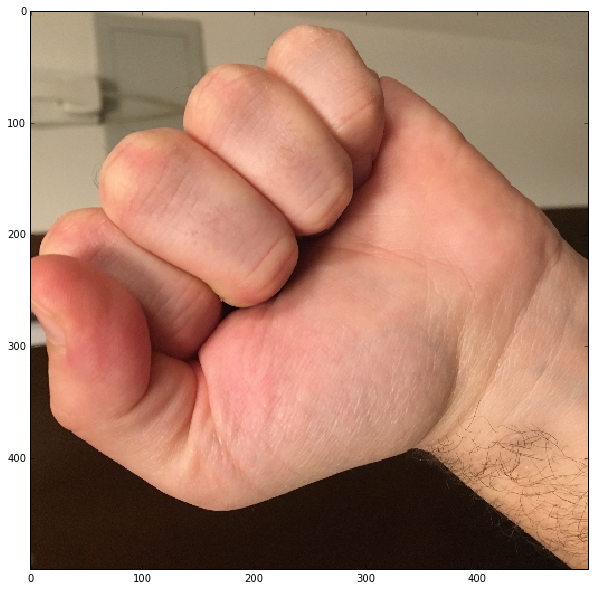

In [16]:
%matplotlib inline
examples=list(dataset_tr["image"])
interact(
    imgplotList, 
    i=widgets.IntSlider(min=0,max=len(examples)-1, step=1, value=0,continuous_update=False), 
    data=fixed(examples))

## Step 4: define what we feed to the Neural Network

In [41]:
def transform_simple(im,sz):
    imr = skimage.transform.resize(im, (sz,sz))
    return imr

def transform_complex(im,sz):
    if(np.random.rand()<0.5):
        im=np.fliplr(im)
    tf1 = skimage.transform.SimilarityTransform(scale = 1 / im.shape[0])
    tf2 = skimage.transform.SimilarityTransform(translation=[-0.5, -0.5])
    tf3 = skimage.transform.SimilarityTransform(rotation=np.deg2rad(np.random.uniform(0,360)))
    tf4 = skimage.transform.SimilarityTransform(scale=np.random.uniform(1,1.6))
    tf5 = skimage.transform.SimilarityTransform(translation=np.array([0.5, 0.5])+np.random.uniform(-0.1,0.1,size=2))
    tf6 = skimage.transform.SimilarityTransform(scale=sz)
    imr = skimage.transform.warp(im, (tf1+(tf2+(tf3+(tf4+(tf5+tf6))))).inverse, output_shape=(sz,sz),mode="edge")
    imr = imr*np.random.uniform(0.9,1.1,size=(1,1,3))
    #imr = np.repeat(np.mean(imr,axis=2)[:,:,np.newaxis],repeats=3,axis=2)
    #imr = (imr - np.mean(imr))/np.std(imr)/5+0.5
    imr = np.clip(imr,0,1)
    return imr

transform=transform_simple

In [42]:
def sample(df,sz):
    r=df.sample(n=1)
    l=r["label"].iloc[0]
    im=r["image"].iloc[0]
    im=transform(im,sz)
    return im,l

def mktrte(df,N,sz):
    X = []
    y = []
    for i in range(N):
        im,l=sample(df,sz)
        X.append(im)
        y.append(l)
    X=np.array(X).astype('float32')
    y=np.array(y)
    y=keras.utils.np_utils.to_categorical(y,3)
    return X,y

def generator(df,batch_size,sz):
    while True:
        X,y = mktrte(df,batch_size,sz)
        yield (X,y)


In [ ]:
# Visualize 100 images from our input dataset
examples = list(mktrte(dataset_tr,100,patchsize)[0])
interact(imgplotList, i=widgets.IntSlider(min=0, max=len(examples)-1, step=1, value=0,continuous_update=False), data=fixed(examples))

In [ ]:
# Visualize 100 variations from our first input image
examples = list(mktrte(dataset_tr.iloc[[0]],100,patchsize)[0])
interact(imgplotList, i=widgets.IntSlider(min=0, max=len(examples)-1, step=1, value=0,continuous_update=False), data=fixed(examples))

In [19]:
# Save pics of augmentations
for c in range(3):
    for i,image in enumerate(dataset_tr[dataset_tr["label"]==c].sample(5).image):
        for j in range(10):
            skimage.io.imsave(
                "viz/tr-c{}-{:05d}-aug{:05d}.png".format(c,i,j),transform(image,100))

/home/lale/.local/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))
/home/lale/.local/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))
/home/lale/.local/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))
/home/lale/.local/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))
/home/lale/.local/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))
/home/lale/.local/lib/python3.5/site-packages/skimage/util/d

## Step 5: build and train the neural network

In [43]:
# Keras: Deep Learning library for Theano and TensorFlow
import keras
from keras.utils  import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Dropout

# NN settings
batch_size         = 20
nb_filters         = 5     # number of convolutional filters to use
pool_size          = (2,2) # size of pooling area for max pooling
kernel_size        = (3,3) # convolution kernel size

model = Sequential()
model.add(Conv2D(nb_filters, kernel_size, padding='valid', input_shape=(patchsize,patchsize,3))) # 3 perchè rgb
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, kernel_size))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Conv2D(nb_filters, kernel_size))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Conv2D(nb_filters, kernel_size))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Flatten())  #  
model.add(Dense(128)) # generate a fully connected layer wiht 128 outputs (arbitrario)
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3)) # output layer
model.add(Activation('softmax')) # output activation per renderle probabilità

## compile! network
model.compile(loss='categorical_crossentropy',
              optimizer="adadelta",
              metrics=['accuracy'])
print(model.count_params())

24385


Build a set of 1000 testing instances taken from the testing dataset.

Note: "testing" is synonym with "validation"

In [37]:
(X_test,y_test) = mktrte(dataset_te, 1000, patchsize)

# Prepare the logs directory, if it does not exist
(pathlib.Path(".")/"logs").mkdir(exist_ok=True)

While the network trains, we can monitor training loss/accuracy and testing loss/accuracy using tensorboard at http://0.0.0.0:6006

You may need to launch tensorboard first if it's not already running, by executing

`tensorboard --logdir=logs`

in a shell with the current working directory.  Check that you are within the proper conda environment, if applicable.

In [44]:
history=model.fit_generator(
                    generator(dataset_tr, batch_size, patchsize),
                    steps_per_epoch=50, 
                    epochs=5000, 
                    verbose=1,
                    validation_data=(X_test,y_test),
                    callbacks=[keras.callbacks.TensorBoard(log_dir='./logs/'+time.strftime("%Y%m%d%H%M%S"), histogram_freq=0, write_graph=False, write_images=False)])

Epoch 1/5000
50/50 [==============================] - 10s - loss: 1.0969 - acc: 0.3540 - val_loss: 1.1363 - val_acc: 0.1320
Epoch 2/5000
50/50 [==============================] - 9s - loss: 1.0906 - acc: 0.3940 - val_loss: 1.1476 - val_acc: 0.1320
Epoch 3/5000
50/50 [==============================] - 8s - loss: 1.0909 - acc: 0.3820 - val_loss: 1.1412 - val_acc: 0.1320
Epoch 4/5000
50/50 [==============================] - 9s - loss: 1.0821 - acc: 0.3990 - val_loss: 1.1541 - val_acc: 0.1320
Epoch 5/5000
50/50 [==============================] - 11s - loss: 1.0765 - acc: 0.4260 - val_loss: 1.1652 - val_acc: 0.1330
Epoch 6/5000
50/50 [==============================] - 8s - loss: 1.0704 - acc: 0.4150 - val_loss: 1.1199 - val_acc: 0.2330
Epoch 7/5000
50/50 [==============================] - 8s - loss: 1.0498 - acc: 0.4590 - val_loss: 1.0975 - val_acc: 0.3600
Epoch 8/5000
50/50 [==============================] - 10s - loss: 1.0407 - acc: 0.4530 - val_loss: 1.0890 - val_acc: 0.3660
Epoch 9/5000


KeyboardInterrupt: 

In [40]:
history


%matplotlib nbagg

import matplotlib.pyplot as plt
import pathlib
import skimage
import skimage.transform
import skimage.viewer
import pandas as pd
import numpy as np
import time
import keras.utils.np_utils

dnames = ["D{}".format(i) for i in range(1,6)]+["testing"]
ddirs=[pathlib.Path(".")/"datasets"/"final split"/dn for dn in dnames] # directories of the dataset

cdirs={}
for ddir in ddirs:
    cdirs.update({ddir/"c0":0,
                  ddir/"c1":1,
                  ddir/"c2":2})
names = ["rock", "paper", "scissors"]
for d in cdirs.keys():
    assert(d.exists())
imagesize = 500
patchsize = 64

dataset=[]

from tqdm import tqdm
for cdir,cn in cdirs.items():
    for f in tqdm(list(cdir.glob("*"))):
        im=skimage.io.imread(f)
        h,w=im.shape[0:2] # height, width
        sz=min(h,w)
        im=im[(h//2-sz//2):(h//2+sz//2),(w//2-sz//2):(w//2+sz//2),:] # defines the central square
        im=skimage.transform.resize(im,(imagesize,imagesize)) # resize it to 500x500, whatever th

In [39]:
# Save results
dataset_te.to_pickle("model_tr1234te5.testingdata.pickle")
keras.models.save_model(model,"model_tr1234te5.model")

In [ ]:
model=keras.models.load_model("model_600.model")

## Step 6: Process the images of the testing set one by one
And visualize the results

[[ 0.93906587  0.05595516  0.00497903]]


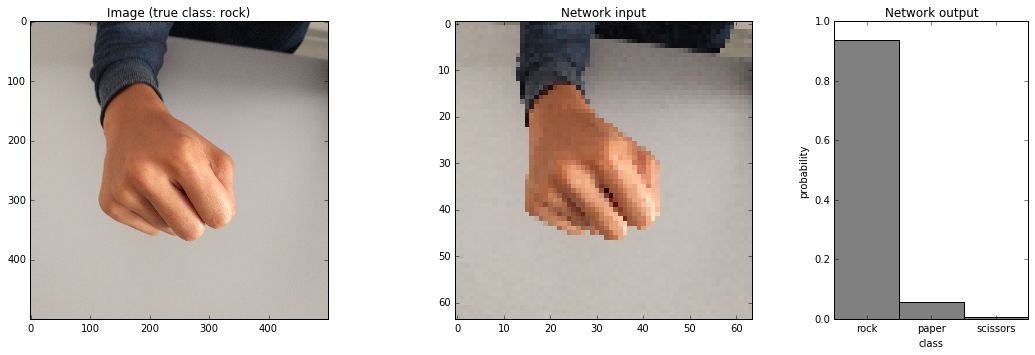

[[ 0.93906587  0.05595516  0.00497903]]


In [33]:
# Show results by processing a single variation of the testing image

%matplotlib inline
def resultsShow(i, data, model):
    d = data.iloc[i]
    im = d["image"]
    l = d["label"]
    fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(15,5),gridspec_kw={'width_ratios':[1,1,0.5]})
    
    imt = transform_simple(im, patchsize)
    axs[0].imshow(im)
    axs[0].set_title("Image (true class: {})".format(names[l]))
    
    axs[1].imshow(imt,interpolation="nearest")
    axs[1].set_title("Network input")
    
    outs = model.predict(np.array([imt]))
    print(outs)
    predicted = np.argmax(outs)
    axs[2].bar(np.array(range(len(names)))-0.5, outs[0,:], 1, color="gray")
    axs[2].set_ylim([0,1])
    axs[2].set_xticks(range(len(names)))
    axs[2].set_xticklabels(names)
    axs[2].set_ylabel("probability")
    axs[2].set_xlabel("class")
    axs[2].set_title("Network output")
    fig.tight_layout()
    plt.show()
    fig.savefig("out_{:05d}_{}.png".format(i,("ok" if predicted==l else "ko")))
    print(outs)

interact(resultsShow, i=widgets.IntSlider(min=0,max=len(dataset_te)-1, step=1, value=0, continuous_update=False), data=fixed(dataset_te.sample(len(dataset_te))), model=fixed(model))


In [29]:
dataset_te.sample(len(dataset_te))

KeyboardInterrupt: 

In [ ]:
from keras import backend as K

def plot_hidden_layers(imt,nmaps=4):
    fig = plt.figure(figsize=(15, 10))
    plt.title('Hidden layers', loc='center')
    plt.axis('off')
    layers = [model.layers[0].input] + [model.layers[i].output for i in [0,2,5,7,9]]
    for layeri,layer in enumerate(layers):
        get = K.function([model.layers[0].input], [layer])
        layeroutputs = get([imt[np.newaxis,:,:,:]])[0][0]
        for j in range(nmaps): # for each map
            sp2=fig.add_subplot(nmaps,len(layers),layeri+1+j*len(layers))
            sp2.axis('off')
            if (layeroutputs.shape[2]>j):
                vmin,vmax = ((0,1) if layeri == 0 else (-0.3,+0.3))
                sp2.imshow(layeroutputs[:,:,j],
                           cmap="gray",
                           interpolation="nearest")
    fig.tight_layout()

imt=transform(dataset_te["image"].iloc[1],patchsize)
plot_hidden_layers(imt)


In [ ]:
%matplotlib inline
def resultsShow(i, data, model):
    d = data.iloc[i]
    im = d["image"]
    l = d["label"]
    fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(15,5),gridspec_kw={'width_ratios':[1,1,0.5]})
    
    imt = [transform(im, patchsize) for j in range(100)];
    axs[0].imshow(im)
    axs[0].set_title("Image (true class: {})".format(names[l]))
    
    axs[1].imshow(imt[0],interpolation="nearest")
    axs[1].set_title("Network input")
    
    outs = model.predict(np.array(imt))
    #print(outs)
    outs = np.mean(outs,axis=0)
    
    predicted = np.argmax(outs)
    axs[2].bar(np.array(range(len(names)))-0.5, outs, 1, color="gray")
    axs[2].set_ylim([0,1])
    axs[2].set_xticks(range(len(names)))
    axs[2].set_xticklabels(names)
    axs[2].set_ylabel("probability")
    axs[2].set_xlabel("class")
    axs[2].set_title("Network output")
    fig.tight_layout()
    plt.show()
    #fig.savefig("out_{:05d}_{}.png".format(i,("ok" if predicted==l else "ko")))
    print(outs)

interact(resultsShow, i=widgets.IntSlider(min=0,max=len(dataset_te)-1, step=1, value=0, continuous_update=False), data=fixed(dataset_te), model=fixed(model))


# Code below is unfinished, ignore

In [ ]:
np.argmax(np.array([1,2,3]))

In [ ]:
dataset_te["label"]

In [ ]:
# Fixes a quirk on Alessandro's PC
import sys
sys.path.remove("/opt/ros/kinetic/lib/python2.7/dist-packages")

In [ ]:

while True:
    ret_val, img = cam.read()
    if ~ret_val:
        break
    cv2.imshow('my webcam', img)
    if cv2.waitKey(1) == 27: 
        break  # esc to quit
cv2.destroyAllWindows()

In [ ]:
import cv2
cam = cv2.VideoCapture(0)
ret_val, img = cam.read()
assert(ret_val)

def getpic(i):
    ret_val, img = cam.read()
    img=img[:,:,[2,1,0]]
    h,w=img.shape[0:2] # height, width
    sz=min(h,w)
    img=img[(h//2-sz//2):(h//2+sz//2),(w//2-sz//2):(w//2+sz//2),:] # defines the central square
    img=skimage.transform.resize(img,(imagesize,imagesize)) # resize it to 500x500, whatever the original resolution

    fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(15,5))

    imt = skimage.transform.resize(img, (patchsize,patchsize))
    axs[0].imshow(imt)

    outs = model.predict(np.array([imt]))
    axs[1].bar(np.array(range(len(names)))-0.5, outs[0], 1, color="black")
    axs[1].set_ylim([0,1])
    axs[1].set_xticks(range(len(names)))
    axs[1].set_xticklabels(names)
    plt.show()
    
interact(getpic, i=widgets.IntSlider(min=0,max=10, step=1, value=0, continuous_update=False))

In [ ]:
cam.release()

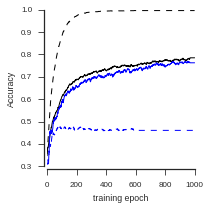

In [104]:
runs={"aug1":"20170925202845",
      "aug0":"20170925233307"}
trtes={"tr":"acc",
      "te":"val_acc"}

df=pd.DataFrame(index=range(1000))
for runn,run in runs.items():
    for trten,trte in trtes.items():
        tdf=pd.read_csv("viz/plots/run_{},tag_{}.csv".format(run,trte)).set_index("Step")
        df[runn+trten]=tdf["Value"]

df[df<0.33]=df[df<0.33]+(df[df<0.33]*-1+0.33)*0.9
df=df.ewm(alpha=0.1).mean()

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']=200
sns.set_style("ticks")
sns.set_context("paper")
fig,ax=plt.subplots(figsize=(3,3))
ax.plot(df["aug0tr"],'--k', linewidth=1)
ax.plot(df["aug0te"],'--b', linewidth=1)
ax.plot(df["aug1tr"],'-k', linewidth=1)
ax.plot(df["aug1te"],'-b', linewidth=1)
#ax.axhline(1/3,color="gray",linewidth=3,alpha=0.3)
ax.set(ylabel="Accuracy",
       xlabel="training epoch",
       ylim=[0.3,1.001])
sns.despine(offset=3)
fig.tight_layout()
fig.savefig("plots.pdf")

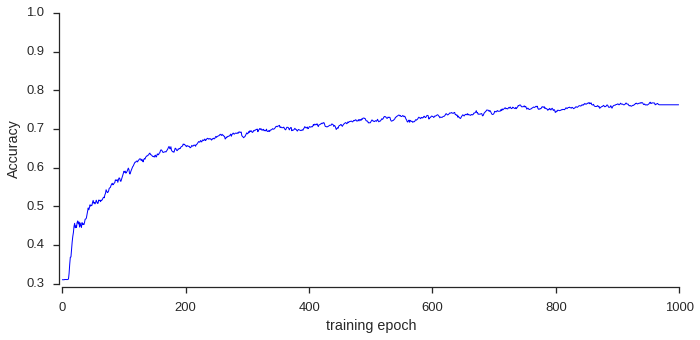

In [116]:
sns.set_style("ticks")
sns.set_context("talk")
fig,ax=plt.subplots(figsize=(10,5))
hs=[]
hs.append(ax.plot(df["aug0tr"],'--k', linewidth=1))
hs.append(ax.plot(df["aug0te"],'--b', linewidth=1))
hs.append(ax.plot(df["aug1tr"],'-k', linewidth=1))
hs.append(ax.plot(df["aug1te"],'-b', linewidth=1))
#ax.axhline(1/3,color="gray",linewidth=3,alpha=0.3)
ax.set(ylabel="Accuracy",
       xlabel="training epoch",
       ylim=[0.3,1.001])
sns.despine(offset=3)
fig.tight_layout()
fig.savefig("plots.png", dpi=300, transparent=True)

for i,h in enumerate(hs):
    [th[0].set_visible(False) for th in hs]
    h[0].set_visible(True)
    fig.savefig("plots_{}.png".format(i), dpi=300, transparent=True)